# CSC 215 - MiniProject 4
## Khoi Hoang

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data.iloc[(i+SEQUENCE_SIZE)]
        window = window.values.tolist()
        x.append(window)
        y.append(after_window[target])
        
    return np.array(x),np.array(y)

# Data Preprocessing

In [3]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [4]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [5]:
# Rearrange the columns
#df = df[['Open', 'High', 'Low', 'Volume', 'Close']]
#df.head()

In [6]:
df.isnull().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [7]:
#df['Open'] = zscore(df['Open'])
#df['High'] = zscore(df['High'])
#df['Low'] = zscore(df['Low'])
#df['Volume'] = zscore(df['Volume'])
encode_numeric_zscore(df, 'Open')
encode_numeric_zscore(df, 'High')
encode_numeric_zscore(df, 'Low')
encode_numeric_zscore(df, 'Volume')
print(df.shape)
df.tail()

(4392, 5)


,Open,High,Low,Close,Volume
4387,2.782154,2.754177,2.787407,113.309998,-0.575988
4388,2.739700,2.735310,2.732368,111.870003,-0.048610
4389,2.723320,2.700885,2.701641,112.230003,0.155816
4390,2.737694,2.714457,2.760732,112.339996,-0.390000
4391,2.732346,2.777017,2.761069,113.190002,-0.167936


In [8]:
x, y = to_xy(df, 'Close')

In [9]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [11]:
x_test.shape

(1318, 4)

# Fully Connected Neural Network

In [13]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Embedding, Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [16]:
checkpointer = ModelCheckpoint(filepath="save/nn.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()

    model.add(Dense(128, input_dim=x_train.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu')) # Hidden 2
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu')) 
    model.add(Dense(1)) # Output

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=500, batch_size=32, shuffle=True)

print('Training finished...Loading the best model')  
print()
model.load_weights("save/nn.hdf5") # load weights from best model    

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 1s - loss: 217.5864 - acc: 0.0013 - val_loss: 185.5187 - val_acc: 7.5873e-04
Epoch 2/500
 - 0s - loss: 41.3716 - acc: 0.0000e+00 - val_loss: 583.7490 - val_acc: 0.0000e+00
Epoch 3/500
 - 0s - loss: 15.4332 - acc: 9.7593e-04 - val_loss: 170.0034 - val_acc: 0.0000e+00
Epoch 4/500
 - 0s - loss: 7.8682 - acc: 0.0016 - val_loss: 93.8360 - val_acc: 7.5873e-04
Epoch 5/500
 - 0s - loss: 5.3680 - acc: 0.0036 - val_loss: 41.5099 - val_acc: 7.5873e-04
Epoch 6/500
 - 0s - loss: 4.5051 - acc: 0.0039 - val_loss: 9.3603 - val_acc: 0.0046
Epoch 7/500
 - 0s - loss: 4.9714 - acc: 0.0013 - val_loss: 2.7803 - val_acc: 0.0023
Epoch 8/500
 - 0s - loss: 4.3819 - acc: 0.0023 - val_loss: 12.1265 - val_acc: 0.0015
Epoch 9/500
 - 0s - loss: 4.0608 - acc: 0.0020 - val_loss: 9.3833 - val_acc: 0.0030
Epoch 10/500
 - 0s - loss: 3.9520 - acc: 0.0033 - val_loss: 18.0746 - val_acc: 7.5873e-04
Epoch 11/500
 - 0s - loss: 3.8372 - acc: 0.0023 - val_loss: 2.688

Epoch 17/500
 - 0s - loss: 3.6393 - acc: 0.0026 - val_loss: 0.5470 - val_acc: 0.0076
Epoch 18/500
 - 0s - loss: 3.7858 - acc: 0.0039 - val_loss: 0.8378 - val_acc: 0.0068
Epoch 19/500
 - 0s - loss: 3.5973 - acc: 0.0042 - val_loss: 0.5200 - val_acc: 0.0068
Epoch 20/500
 - 0s - loss: 3.7316 - acc: 0.0023 - val_loss: 0.9011 - val_acc: 0.0091
Epoch 21/500
 - 0s - loss: 3.2939 - acc: 0.0042 - val_loss: 0.5089 - val_acc: 0.0091
Epoch 22/500
 - 0s - loss: 3.2849 - acc: 0.0036 - val_loss: 1.1693 - val_acc: 0.0053
Epoch 23/500
 - 0s - loss: 3.7013 - acc: 0.0049 - val_loss: 4.2609 - val_acc: 0.0015
Epoch 24/500
 - 0s - loss: 3.2482 - acc: 0.0036 - val_loss: 1.8039 - val_acc: 0.0053
Epoch 25/500
 - 0s - loss: 3.2074 - acc: 0.0036 - val_loss: 0.5585 - val_acc: 0.0076
Epoch 26/500
 - 0s - loss: 3.5507 - acc: 0.0042 - val_loss: 0.4909 - val_acc: 0.0076
Epoch 27/500
 - 0s - loss: 2.9456 - acc: 0.0029 - val_loss: 2.7301 - val_acc: 0.0030
Epoch 28/500
 - 0s - loss: 2.8271 - acc: 0.0026 - val_loss: 1.239

In [17]:
nn_pred = model.predict(x_test)

nn_rmse = np.sqrt(metrics.mean_squared_error(nn_pred, y_test))
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("RMSE score: {}".format(nn_rmse))

-----------------**Fully-Connected Neural Network Report**---------------

RMSE score: 0.6944844722747803


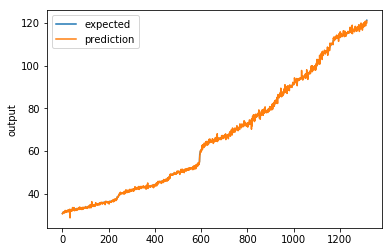

In [18]:
chart_regression(nn_pred.flatten(), y_test)

# LSTM model

In [50]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [51]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [52]:
SEQUENCE_SIZE = 7
#x, y = to_sequences(SEQUENCE_SIZE,df, 'Close')
df_lstm = df.copy().astype('float64')
df_lstm.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600.0
1,4.125000,4.125000,4.000000,4.015625,1077600.0
2,4.000000,4.031250,3.953125,4.000000,437200.0
3,4.000000,4.000000,3.843750,3.843750,1883600.0
4,3.734375,3.734375,3.390625,3.390625,7931600.0


In [53]:
#scaler = preprocessing.StandardScaler()
#df_lstm[['Open']] = scaler.fit_transform(df_lstm[['Open']])
#df_lstm[['High']] = scaler.fit_transform(df_lstm[['High']])
#df_lstm[['Low']] = scaler.fit_transform(df_lstm[['Low']])
#df_lstm[['Close']] = scaler.fit_transform(df_lstm[['Close']])
#df_lstm[['Volume']] = scaler.fit_transform(df_lstm[['Volume']])
encode_numeric_zscore(df_lstm, 'Open')
encode_numeric_zscore(df_lstm, 'High')
encode_numeric_zscore(df_lstm, 'Low')
encode_numeric_zscore(df_lstm, 'Close')
encode_numeric_zscore(df_lstm, 'Volume')
df_lstm = pd.DataFrame(df_lstm, columns=df.columns)

In [54]:
df_lstm.head()

,Open,High,Low,Close,Volume
0,-0.894209,-0.885022,-0.892306,-0.884364,1.104812
1,-0.883762,-0.886056,-0.885975,-0.888021,-0.497301
2,-0.887941,-0.889159,-0.887558,-0.888543,-0.892217
3,-0.887941,-0.890194,-0.891251,-0.893768,-0.000263
4,-0.896820,-0.898986,-0.906551,-0.908920,3.729366


In [55]:
x = []
y = []

for i in range(len(df_lstm)-SEQUENCE_SIZE-1):
    window = df_lstm[i:(i+SEQUENCE_SIZE)]
    after_window = df.iloc[(i+SEQUENCE_SIZE)]
    window = window.values.tolist()
    x.append(window)
    y.append(after_window['Close'])
        
x = np.array(x)
y = np.array(y)

In [56]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x = zscore(x)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [57]:
x_train

array([[[-8.94208763e-01, -8.85021698e-01, -8.92306409e-01,
         -8.84363545e-01,  1.10481203e+00],
        [-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -8.88020865e-01, -4.97300682e-01],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.88543339e-01, -8.92217148e-01],
        ...,
        [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
         -9.08919836e-01,  3.72936618e+00],
        [-9.04655112e-01, -9.00020387e-01, -9.04968586e-01,
         -9.07352413e-01,  5.92175691e+00],
        [-9.03610477e-01, -9.04157956e-01, -9.16575581e-01,
         -9.05262516e-01,  6.93926498e+00]],

       [[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -8.88020865e-01, -4.97300682e-01],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.88543339e-01, -8.92217148e-01],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
         -8.93768082e-01, -2.63405247e-04],
        ...,
        [-9.04655112e-01, -9.0002038

In [58]:
#SEQUENCE_SIZE = 7
#df_train = df[0:int(0.7*len(df))]
#df_test = df[int(0.7*len(df)):]

#x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train, 'Close')
#x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test, 'Close')

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [59]:
checkpointer = ModelCheckpoint(filepath="save/lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(7, 5)))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=128)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/lstm.hdf5") # load weights from best model    

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 5s - loss: 336.5053 - acc: 0.0000e+00 - val_loss: 5126.8090 - val_acc: 0.0000e+00
Epoch 2/1000
 - 1s - loss: 303.5586 - acc: 0.0000e+00 - val_loss: 4164.4851 - val_acc: 0.0000e+00
Epoch 3/1000
 - 1s - loss: 220.6329 - acc: 0.0000e+00 - val_loss: 564288.8869 - val_acc: 0.0000e+00
Epoch 4/1000
 - 1s - loss: 46.5585 - acc: 6.5189e-04 - val_loss: 107299.5907 - val_acc: 0.0000e+00
Epoch 5/1000
 - 1s - loss: 13.3006 - acc: 6.5189e-04 - val_loss: 17009.7371 - val_acc: 0.0000e+00
Epoch 6/1000
 - 1s - loss: 5.3419 - acc: 9.7784e-04 - val_loss: 4863.3780 - val_acc: 7.5988e-04
Epoch 7/1000
 - 1s - loss: 2.1859 - acc: 0.0020 - val_loss: 2474.4538 - val_acc: 7.5988e-04
Epoch 8/1000
 - 1s - loss: 1.1973 - acc: 0.0036 - val_loss: 2162.2710 - val_acc: 0.0015
Epoch 9/1000
 - 1s - loss: 0.9295 - acc: 0.0059 - val_loss: 2637.2893 - val_acc: 7.5988e-04
Epoch 10/1000
 - 1s - loss: 0.8447 - acc: 0.0062 - val_loss: 2545.6908 - val_acc: 0.0015
Ep

In [60]:
lstm_pred = model.predict(x_test)
lstm_rmse = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Score (RMSE): {}".format(lstm_rmse))

Score (RMSE): 46.50022581379519


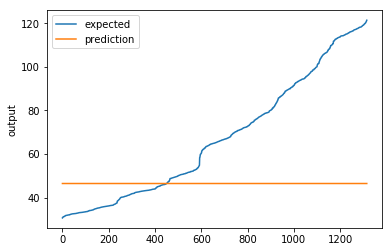

In [61]:
chart_regression(lstm_rmse, y_test)